In [7]:
import pandas as pd
import yfinance as yf

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [9]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055536,0.063703,0.055536,0.060980,1031788800,0.0,0.0
1986-03-14,0.060980,0.064247,0.060980,0.063158,308160000,0.0,0.0
1986-03-17,0.063158,0.064792,0.063158,0.064247,133171200,0.0,0.0
1986-03-18,0.064247,0.064792,0.062069,0.062613,67766400,0.0,0.0
1986-03-19,0.062613,0.063158,0.060980,0.061524,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

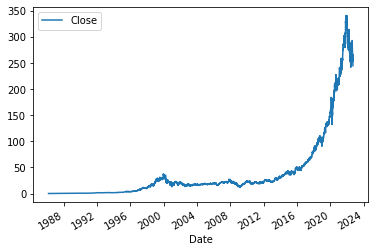

In [4]:
msft_hist.plot.line(y="Close", use_index=True)

In [10]:
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})
data["Target"]= msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [11]:
data.head(5)

,Actual_Close,Target
Date,,
1986-03-13,0.060980,NaN
1986-03-14,0.063158,1.0
1986-03-17,0.064247,1.0
1986-03-18,0.062613,0.0
1986-03-19,0.061524,0.0


In [17]:
msft_prev = msft_hist.copy()

In [18]:
msft_prev = msft_prev.shift(1)

In [19]:
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055536,0.063703,0.055536,0.060980,1.031789e+09,0.0,0.0
1986-03-17,0.060980,0.064247,0.060980,0.063158,3.081600e+08,0.0,0.0
1986-03-18,0.063158,0.064792,0.063158,0.064247,1.331712e+08,0.0,0.0
1986-03-19,0.064247,0.064792,0.062069,0.062613,6.776640e+07,0.0,0.0


In [21]:
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [22]:
data.head(5)

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14,0.063158,1.0,0.060980,0.063703,0.055536,0.055536,1.031789e+09
1986-03-17,0.064247,1.0,0.063158,0.064247,0.060980,0.060980,3.081600e+08
1986-03-18,0.062613,0.0,0.064247,0.064792,0.063158,0.063158,1.331712e+08
1986-03-19,0.061524,0.0,0.062613,0.064792,0.062069,0.064247,6.776640e+07
1986-03-20,0.059891,0.0,0.061524,0.063158,0.060980,0.062613,4.789440e+07


In [29]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

#try max of 500 extimators

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])


RandomForestClassifier(min_samples_split=200, random_state=1)

In [115]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5277382645803699

In [40]:
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
combined.plot()

,Target,Predictions
Date,,
2022-04-26,0.0,1.0
2022-04-27,1.0,1.0
2022-04-28,1.0,1.0
2022-04-29,0.0,1.0
2022-05-02,1.0,1.0
...,...,...
2022-09-12,1.0,1.0
2022-09-13,0.0,1.0
2022-09-14,1.0,1.0


In [110]:
def bcktest(data, model, predictors, start=1000,step=750):
    predictions = []
    for i in range(start, data.shape[0], step):

        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds>0.6] = 1
        preds[preds <= 0.6] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        
        predictions.append(combined)

    return pd.concat(predictions)

In [116]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [117]:
predictions = backtest(data, model, predictors)

In [118]:
predictions["Predictions"].value_counts()

0.0    7547
1.0     656
Name: Predictions, dtype: int64

In [119]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4923780487804878

In [120]:
# possible improvments 
# able to look at the different means, this will provide an expectation of the different trends 
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

#weekly trend: 
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [121]:
#Improving the actual model: 

data["weekly_mean"] = weekly_mean["Close"]/ data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"]/ data["Close"]
data["annual_mean"] = annual_mean["Close"]/ data["Close"]

data["annual_weekly_mean"] = data["annual_mean"]/ data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"]/ data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"]/data["Close"]
data["high_close_ratio"] = data["High"]/data["Close"]
data["low_close_ratio"] = data["Low"]/data["Close"]


In [123]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "weekly_trend", "open_close_ratio", "high_close_ratio", "low_close_ratio"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [124]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5348101265822784

<AxesSubplot:xlabel='Date'>

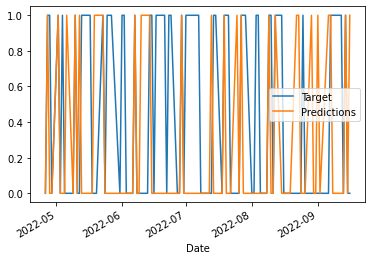

In [127]:
predictions.iloc[-100:].plot()